This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
from cellpose import core
from cellpose import io as cellpose_io
from cellpose import models
import subprocess  # subprocess handling
import shutil

cellpose_io.logger_setup()
import torch
from cellpose.io import imread
from PIL import Image
from skimage import io

use_GPU = torch.cuda.is_available()

# set import path
sys.path.append(str(pathlib.Path("../../utils/").resolve()))

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

2025-01-09 11:37:15,828 [INFO] WRITING LOG OUTPUT TO /home/lippincm/.cellpose/run.log
2025-01-09 11:37:15,829 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.9.21 
torch version:  	2.5.1+cu124
True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--window_size", type=int, help="Size of the window to use for the segmentation"
    )
    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )

    args = parser.parse_args()
    window_size = args.window_size
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)

else:
    input_dir = pathlib.Path("../../data/z-stack_images/C9-1/").resolve(strict=True)
    window_size = 3
    clip_limit = 0.1

mask_path = pathlib.Path(f"../processed_data/{input_dir.stem}").resolve()
mask_path.mkdir(exist_ok=True, parents=True)

## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [32]:
# find the cytoplasmic channels in the image set
for f in files:
    if "405" in f:
        nuclei = io.imread(f)
    elif "488" in f:
        cyto1 = io.imread(f)
    elif "555" in f:
        cyto2 = io.imread(f)
    elif "640" in f:
        cyto3 = io.imread(f)
    elif "TRANS" in f:
        brightfield = io.imread(f)
    else:
        print(f"Unknown channel: {f}")

cyto = np.max([cyto1, cyto2, cyto3], axis=0)
# pick which channels to use for cellpose
cyto = skimage.exposure.equalize_adapthist(cyto2, clip_limit=clip_limit)


original_cyto_image = cyto.copy()

original_cyto_z_count = cyto.shape[0]

In [33]:
# make a 2.5 D max projection image stack with a sliding window of 3 slices
image_stack_2_5D = np.empty((0, cyto.shape[1], cyto.shape[2]), dtype=cyto.dtype)
for image_index in range(cyto.shape[0]):
    image_stack_window = cyto[image_index : image_index + window_size]
    if not image_stack_window.shape[0] == window_size:
        break
    # guassian blur the image stack
    image_stack_window = skimage.filters.gaussian(image_stack_window, sigma=1)
    # max project the image stack
    image_stack_2_5D = np.append(
        image_stack_2_5D, np.max(image_stack_window, axis=0)[np.newaxis, :, :], axis=0
    )

image_stack_2_5D = np.array(image_stack_2_5D)
cyto = np.array(image_stack_2_5D)
print("2.5D cyto image stack shape:", cyto.shape)

2.5D cyto image stack shape: (31, 1537, 1540)


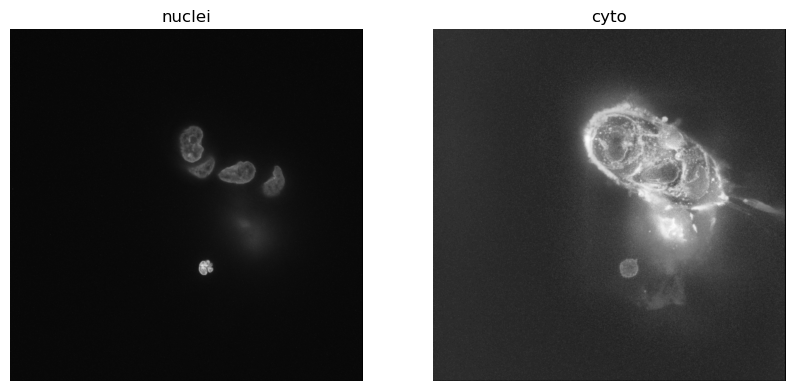

In [34]:
if in_notebook:
    # plot the nuclei and the cyto channels
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(nuclei[9, :, :], cmap="gray")
    plt.title("nuclei")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(cyto[9, :, :], cmap="gray")
    plt.title("cyto")
    plt.axis("off")
    plt.show()

/tmp/ipykernel_3687311/61129895.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


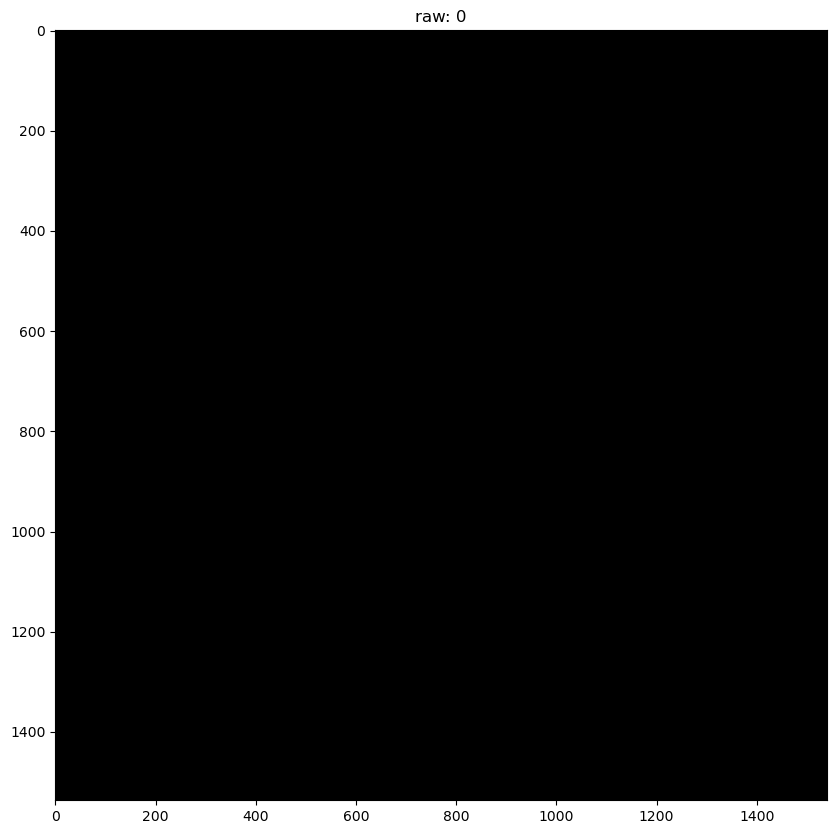

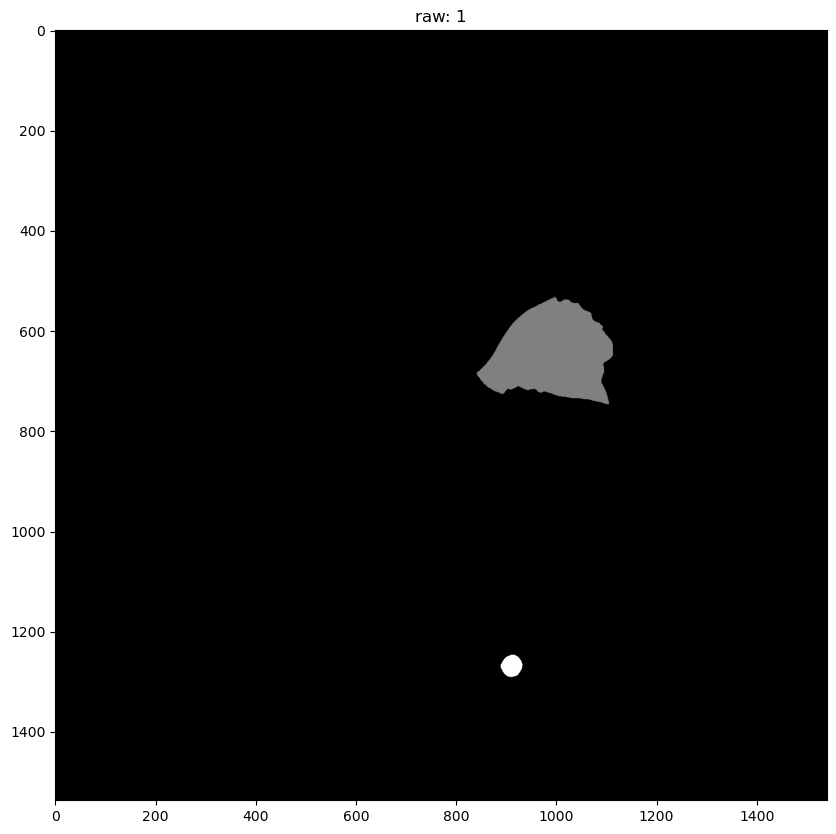

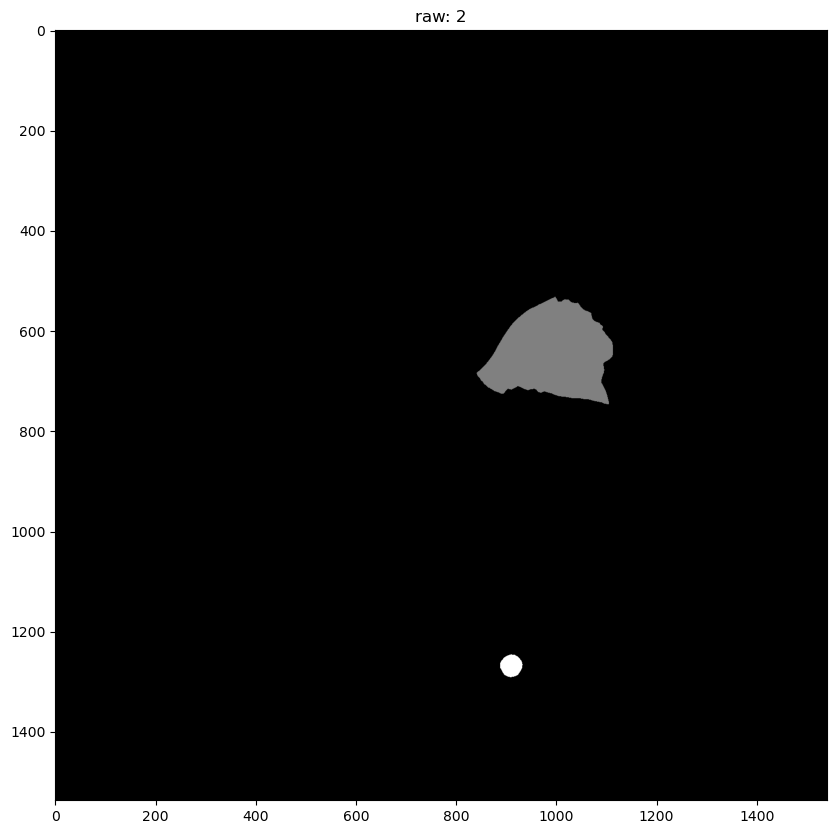

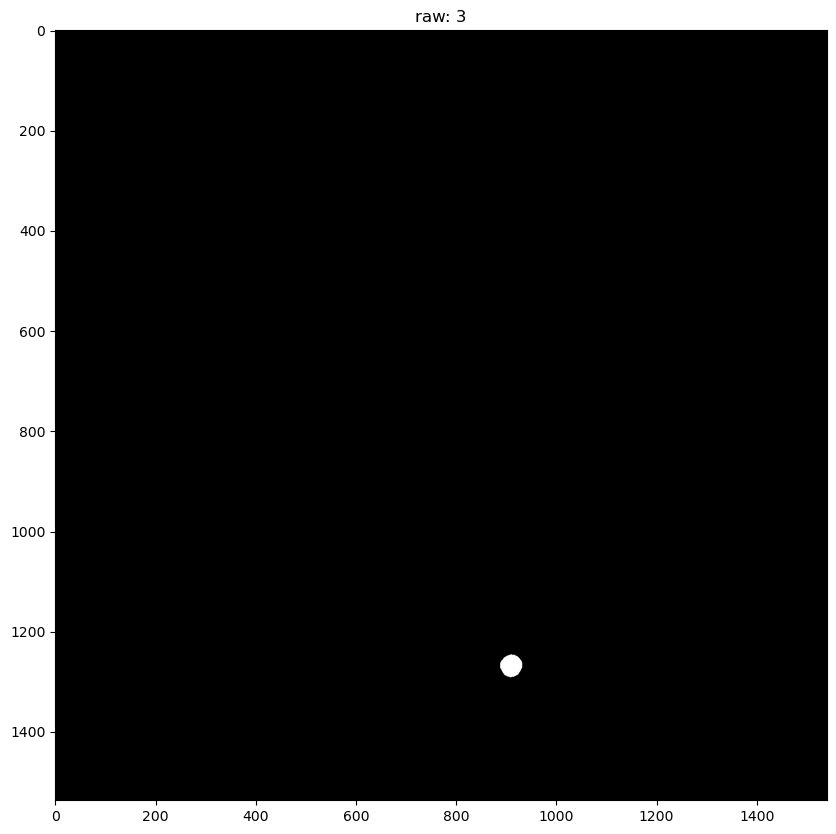

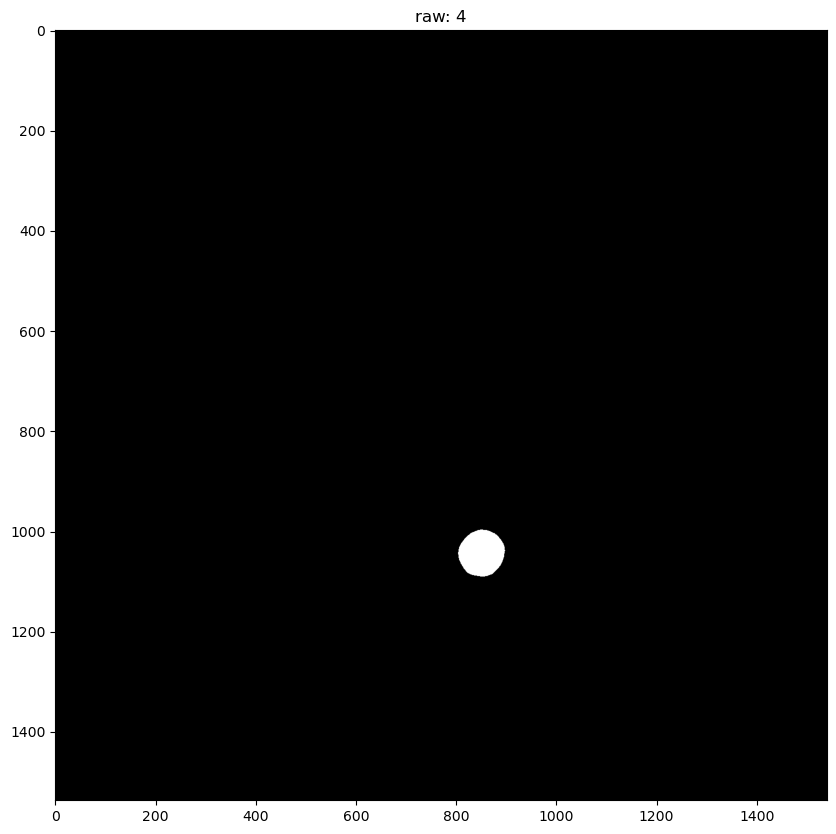

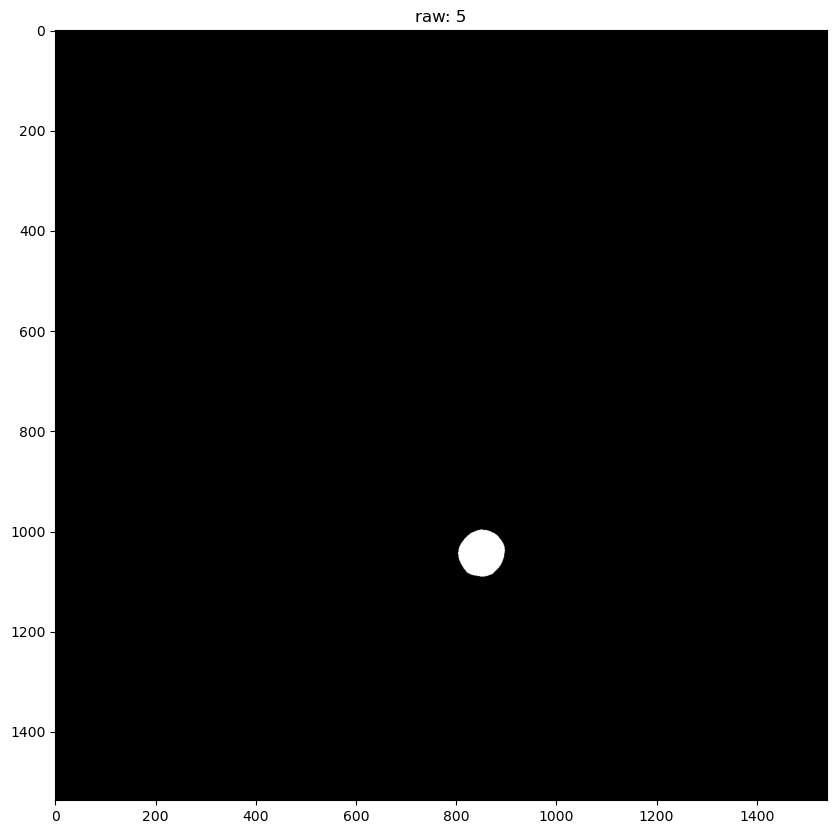

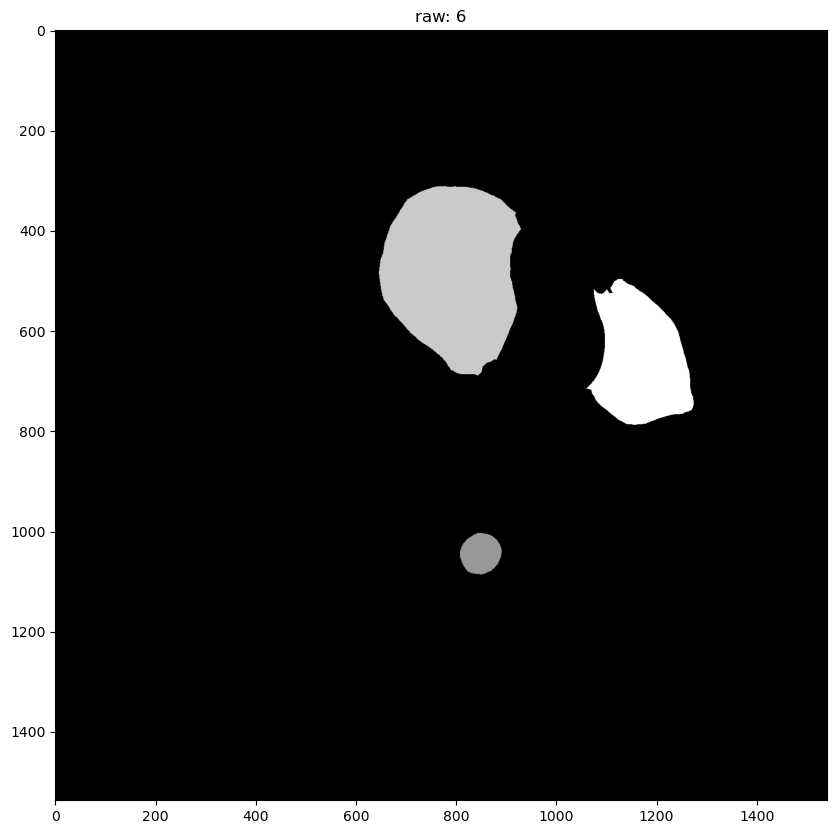

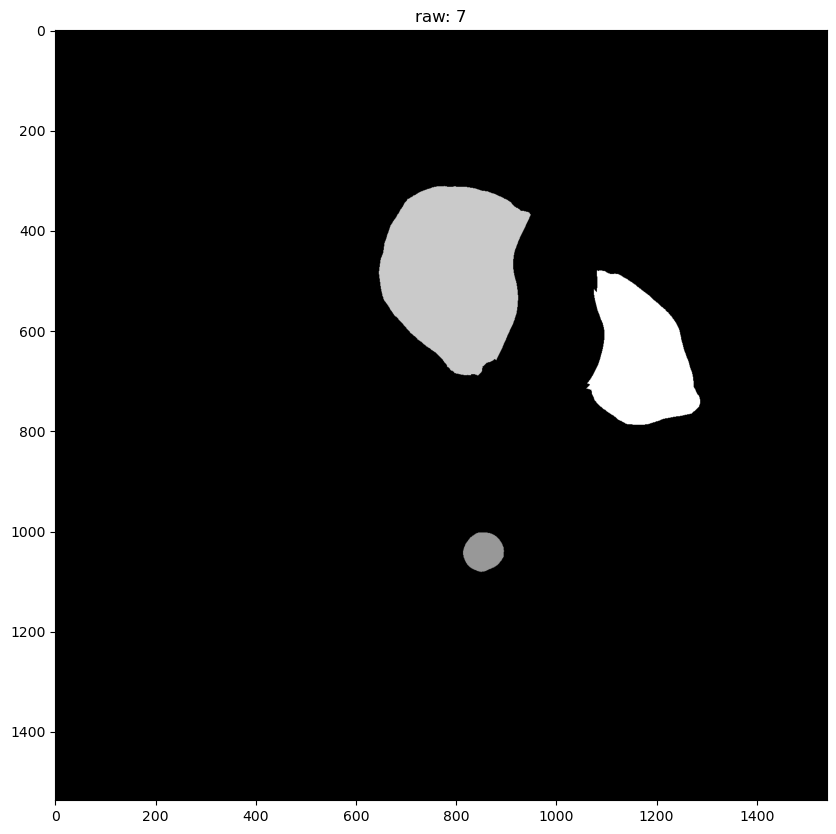

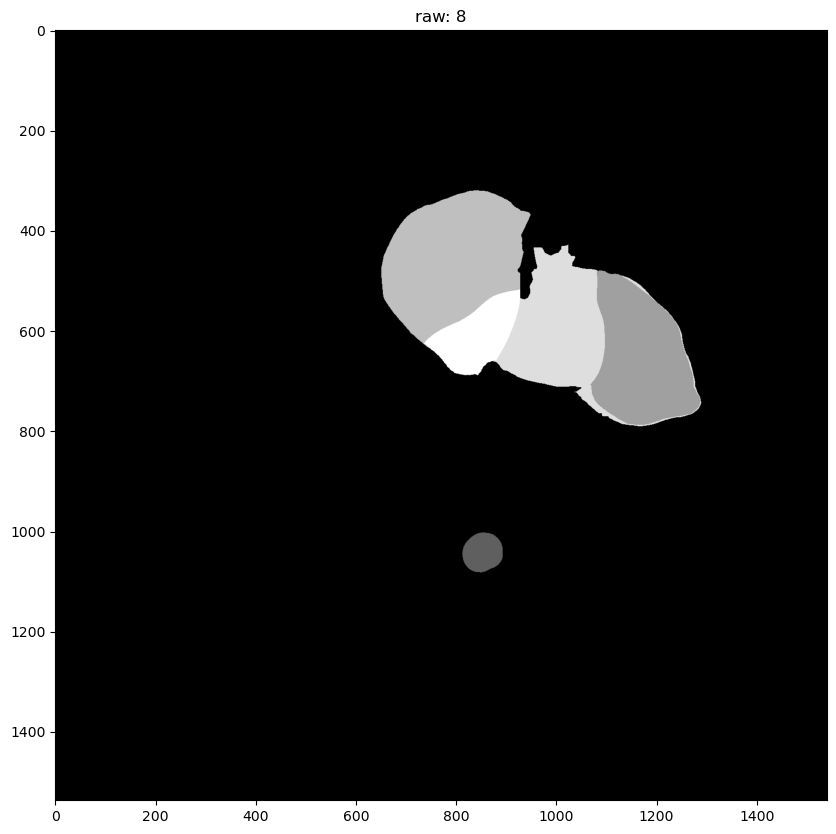

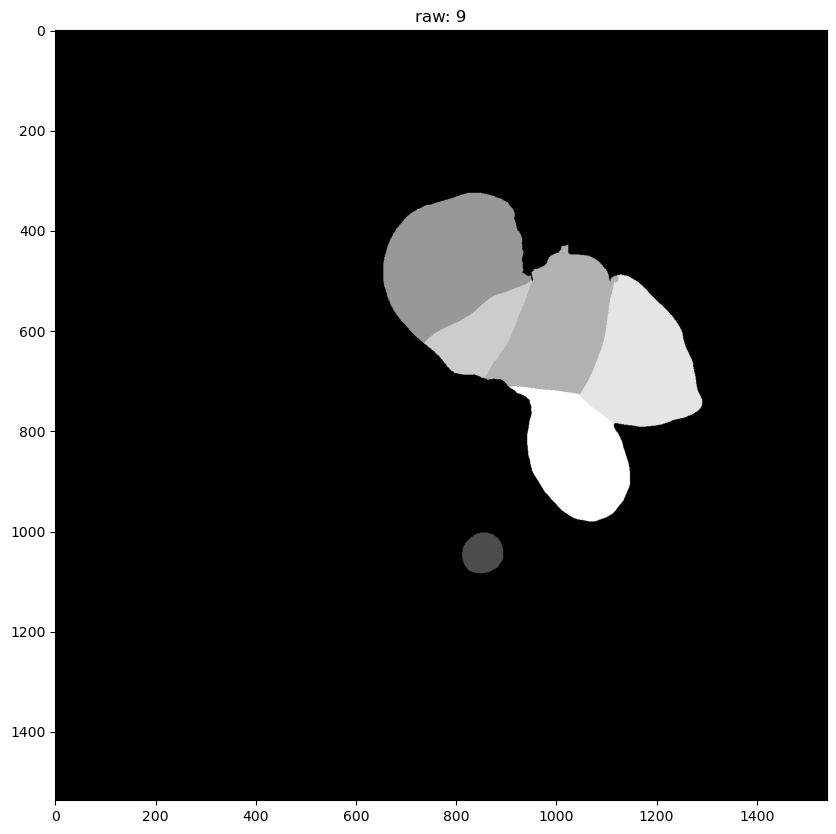

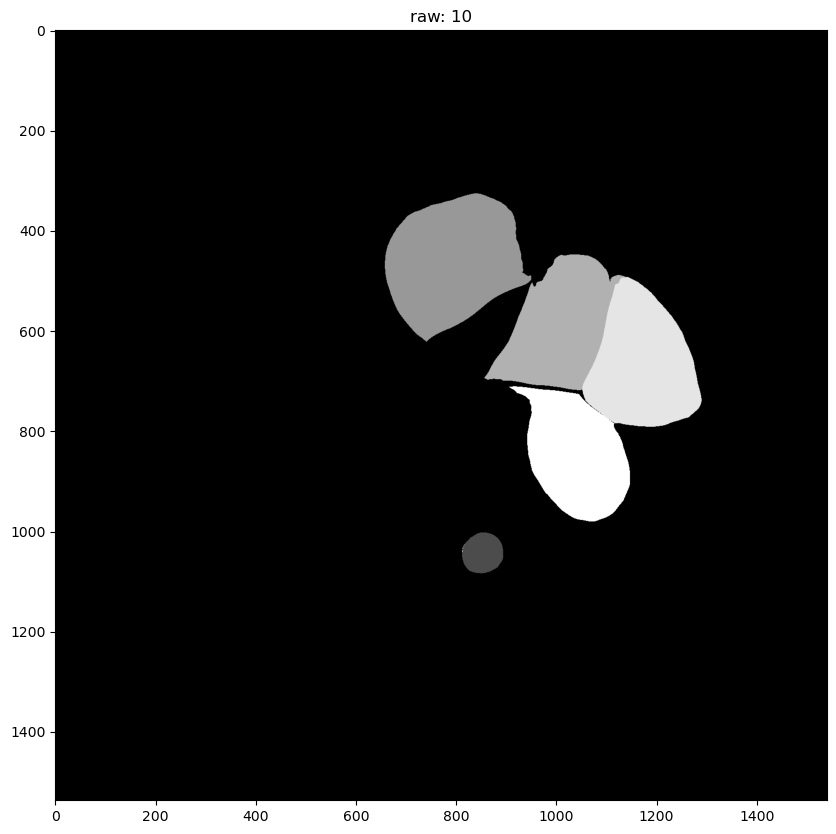

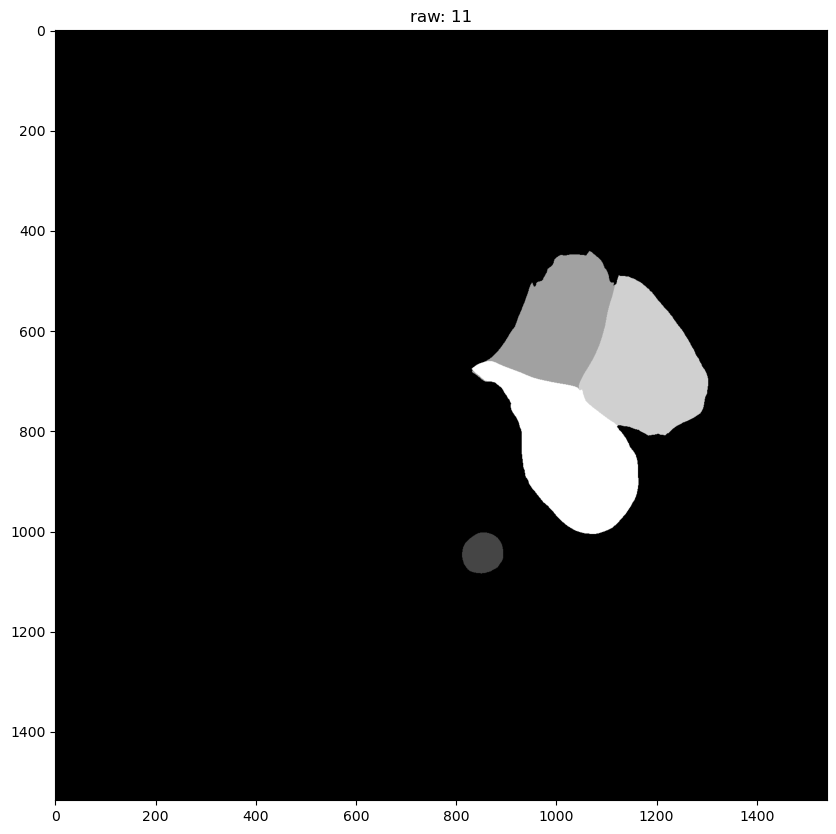

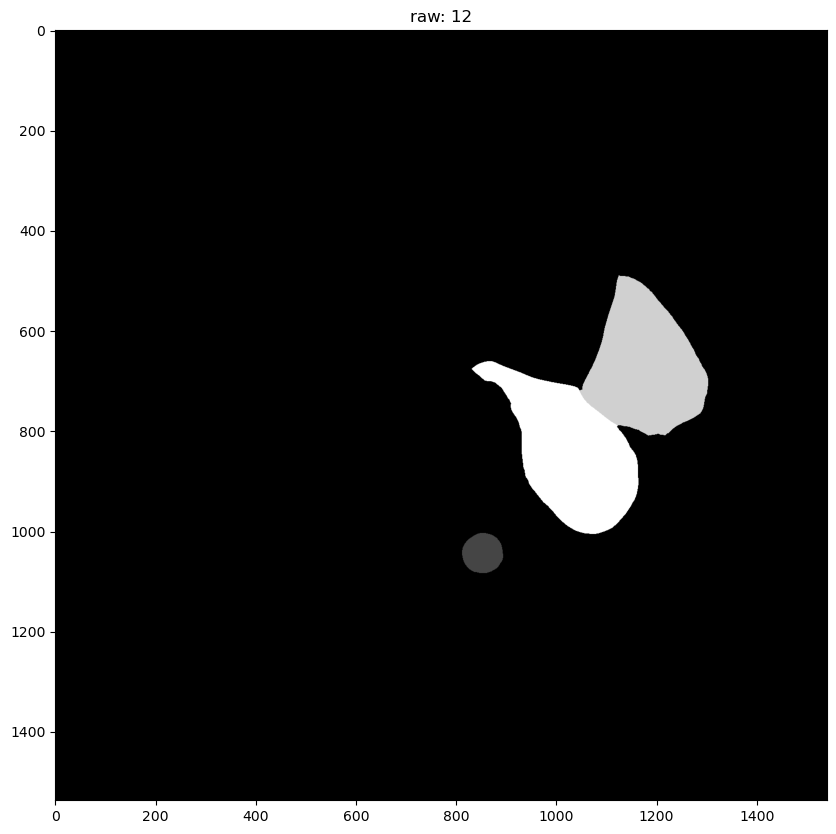

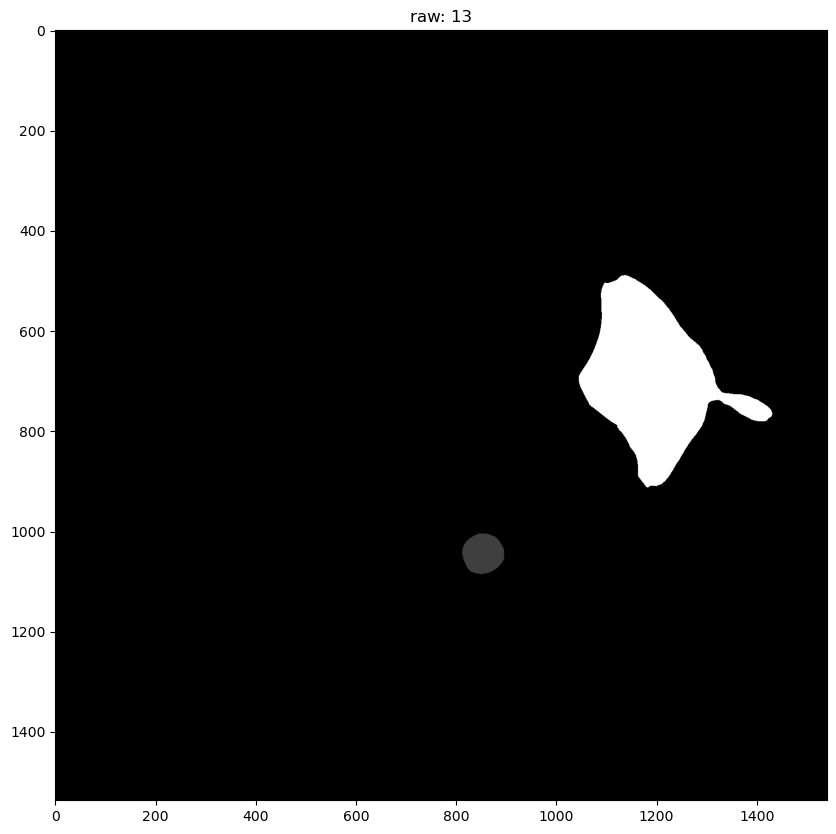

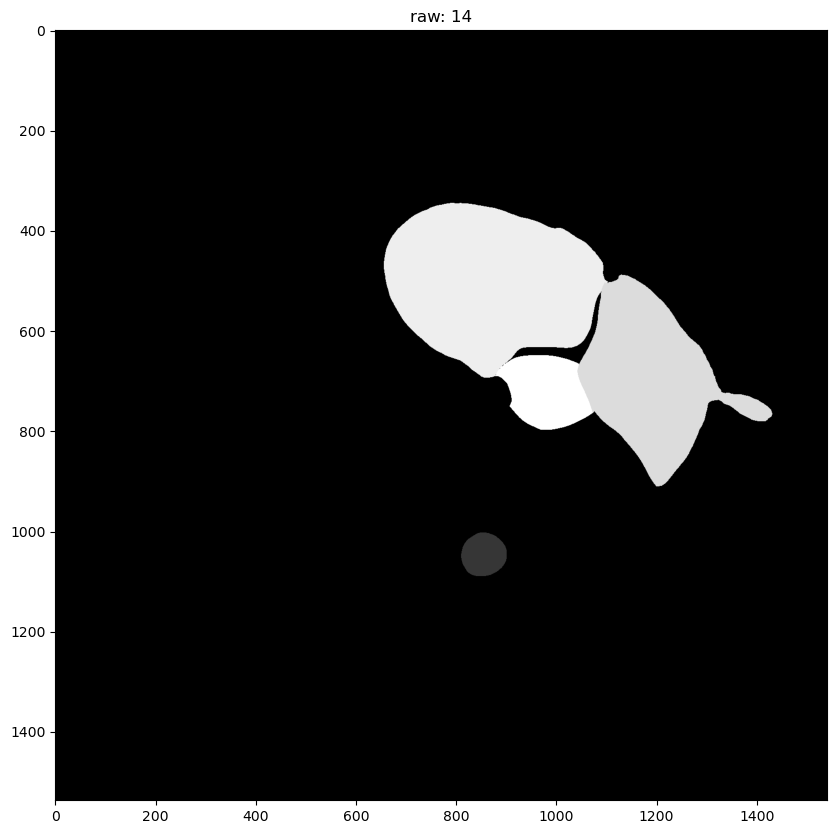

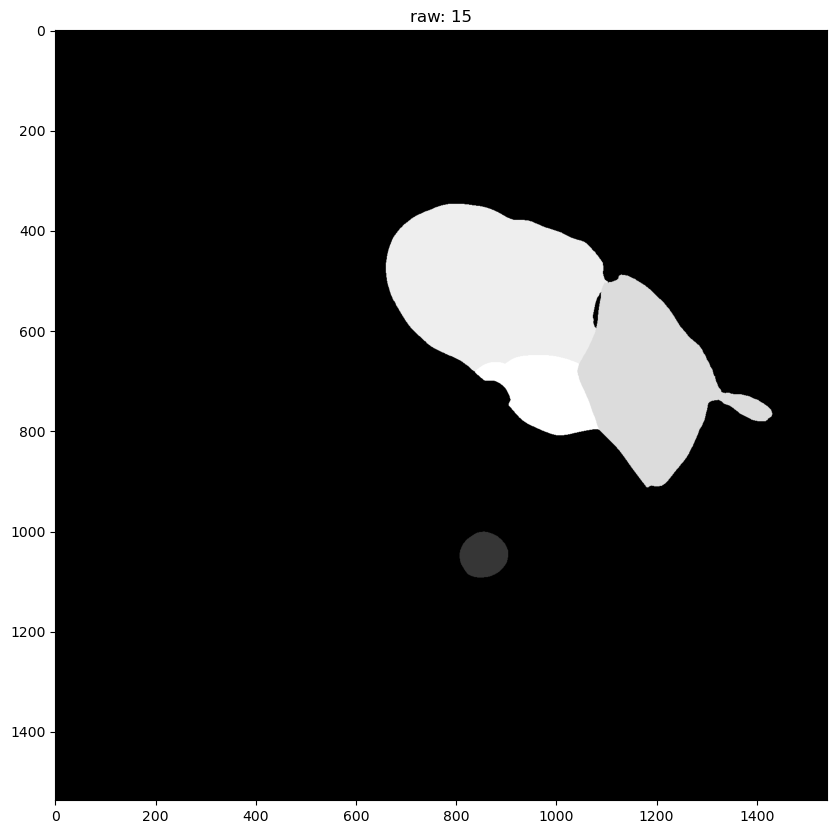

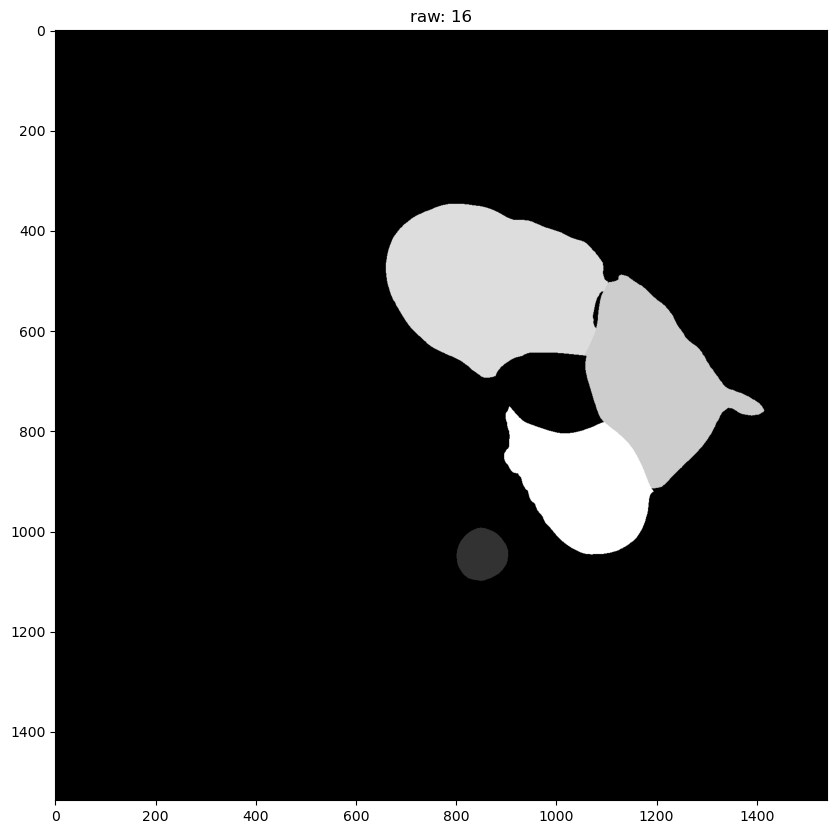

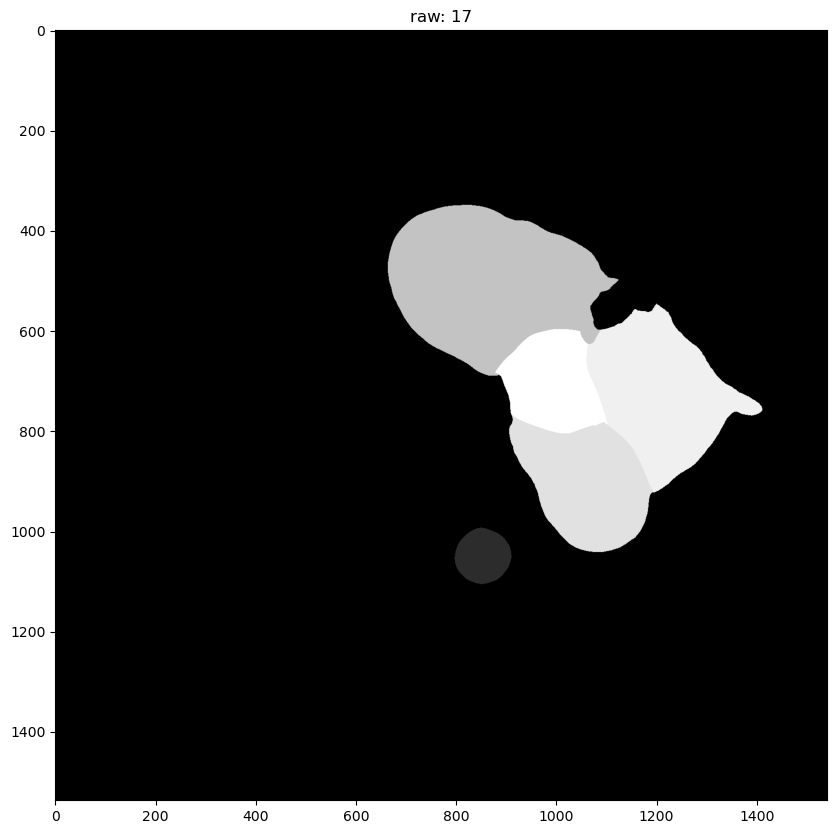

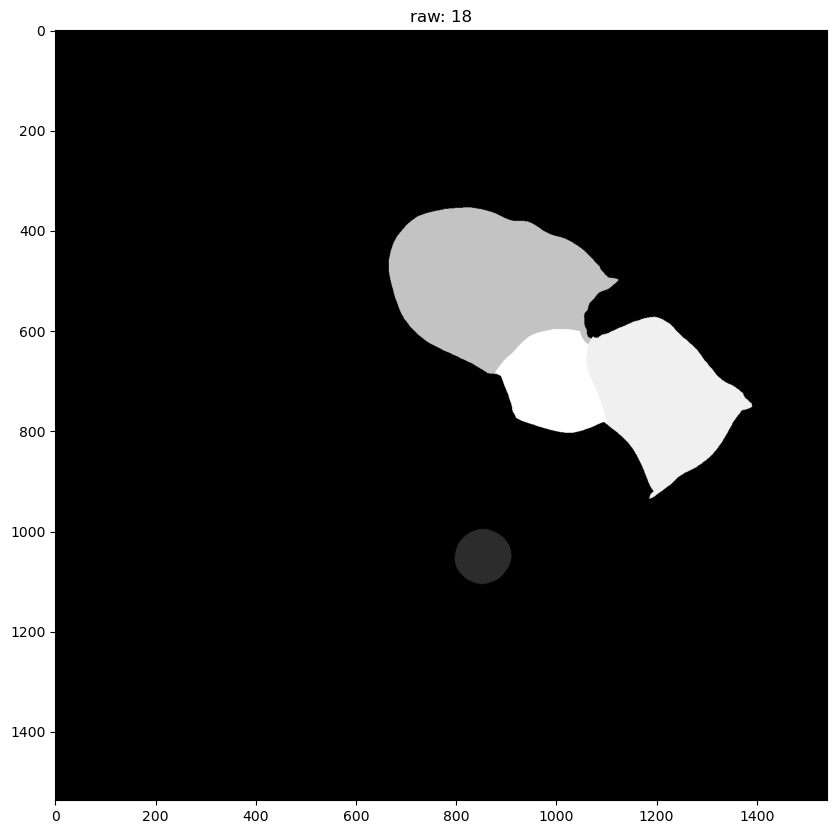

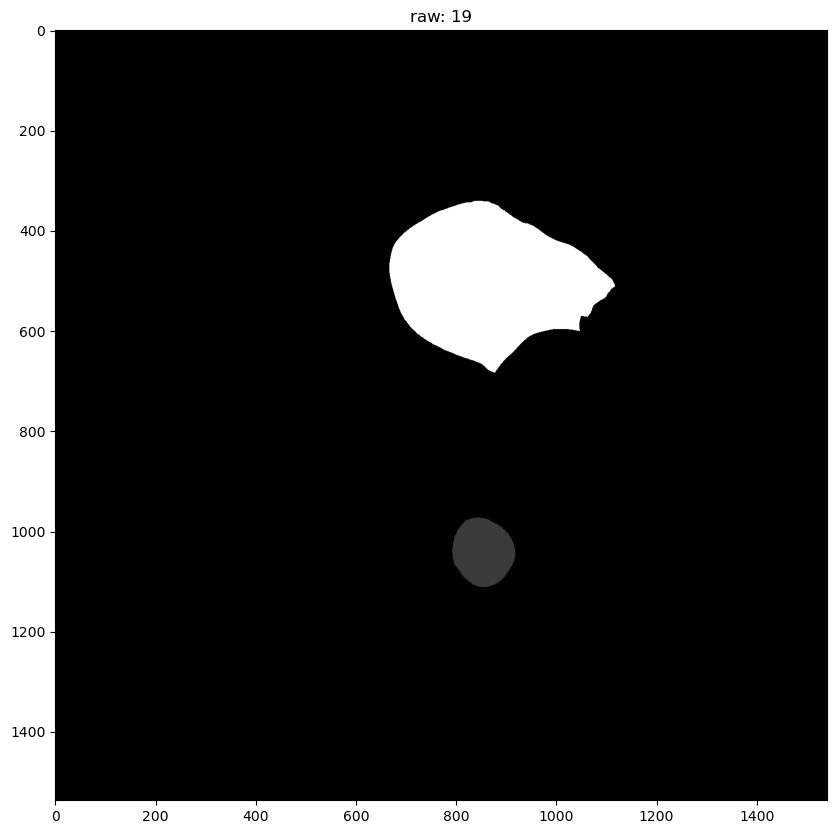

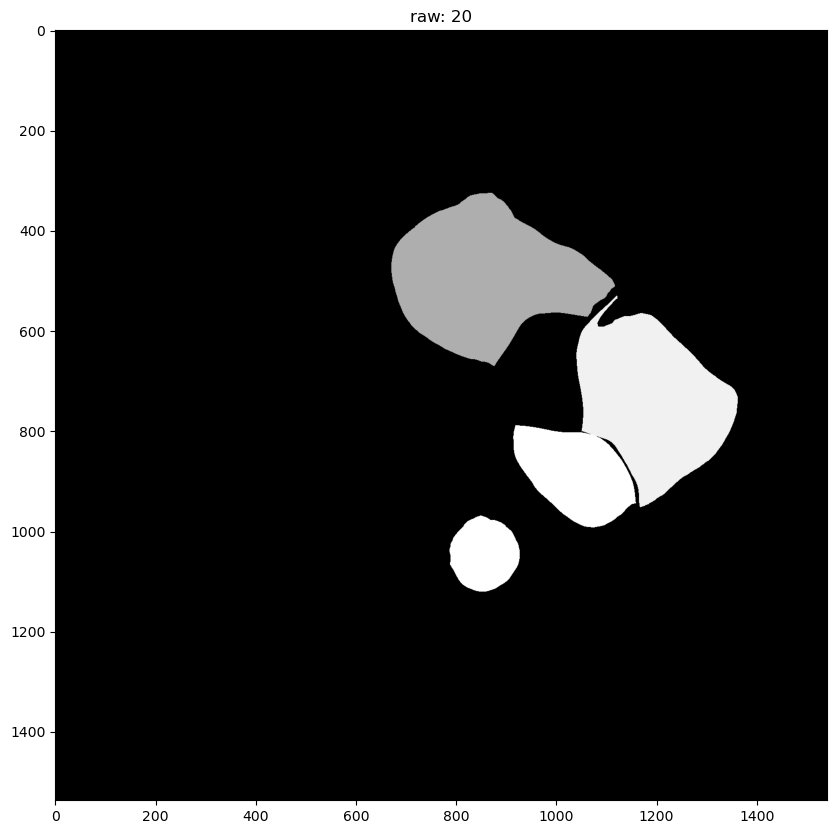

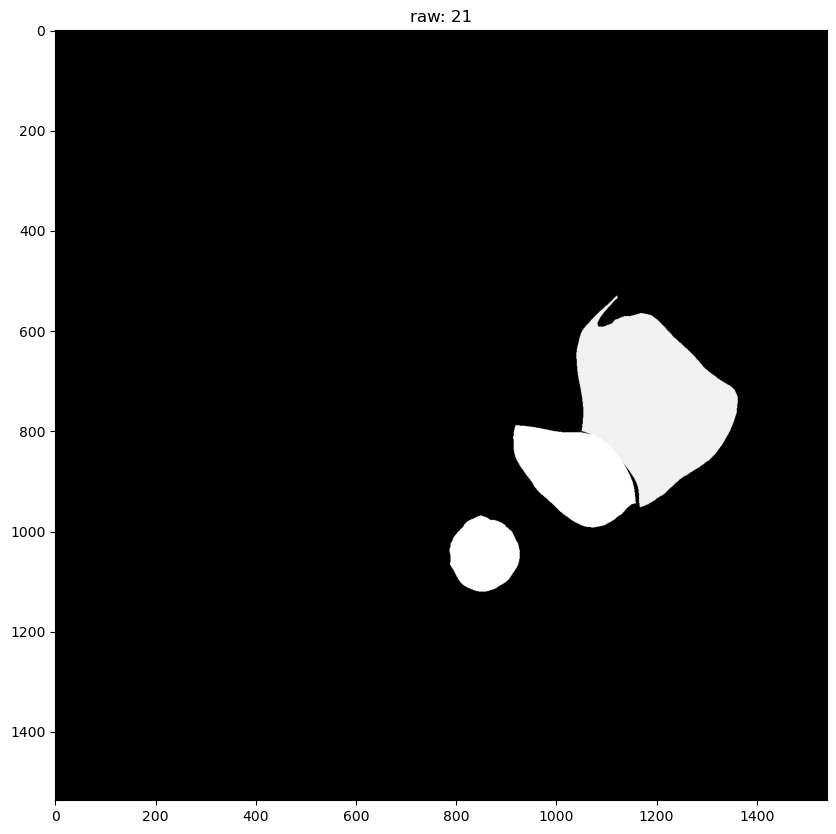

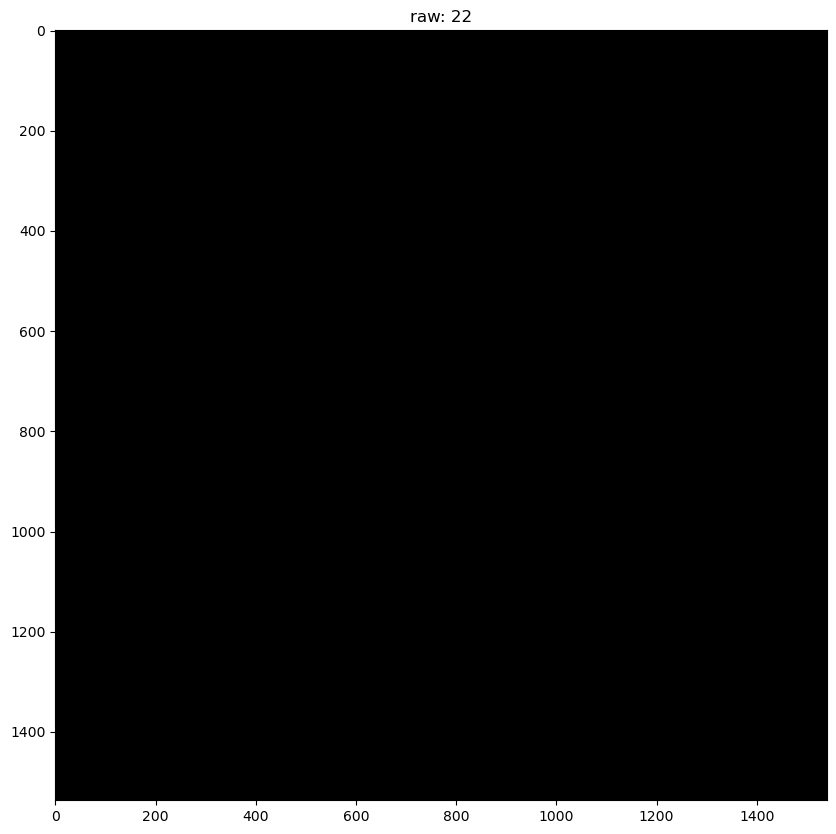

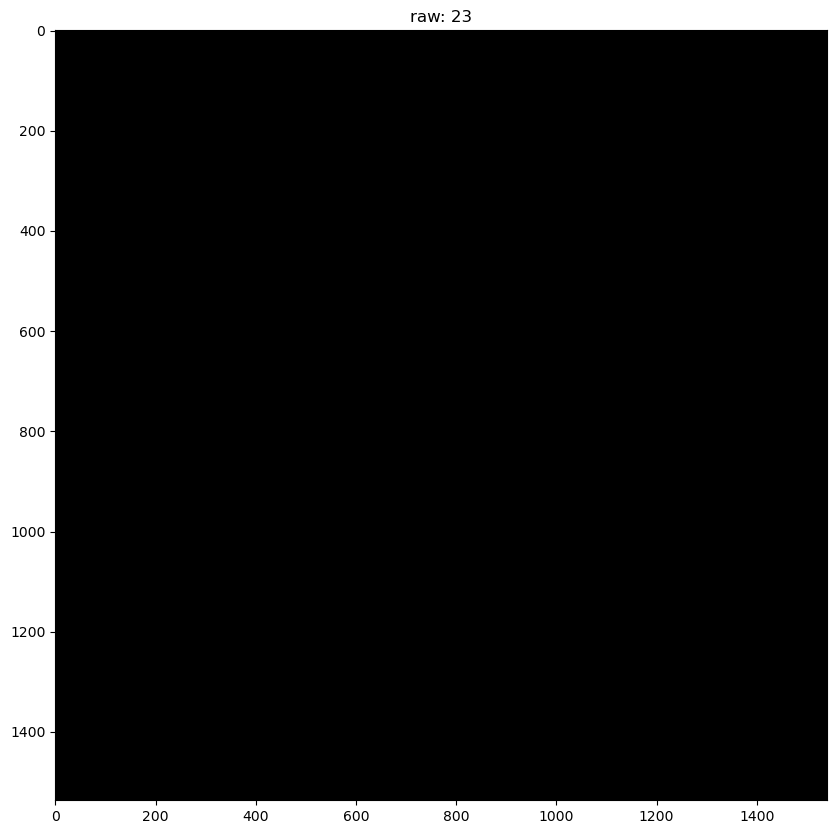

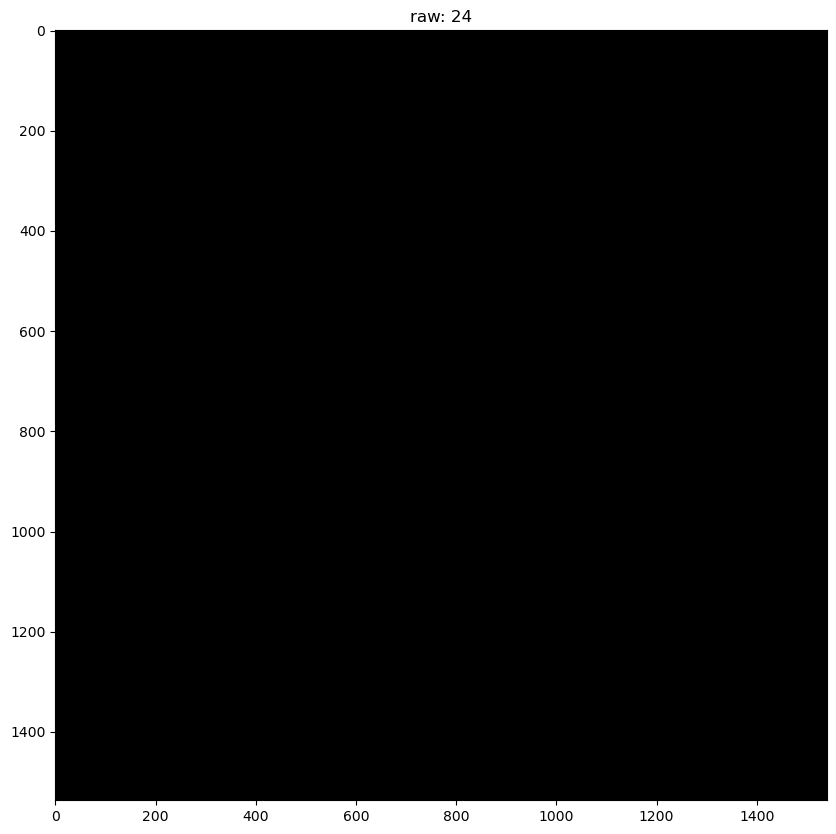

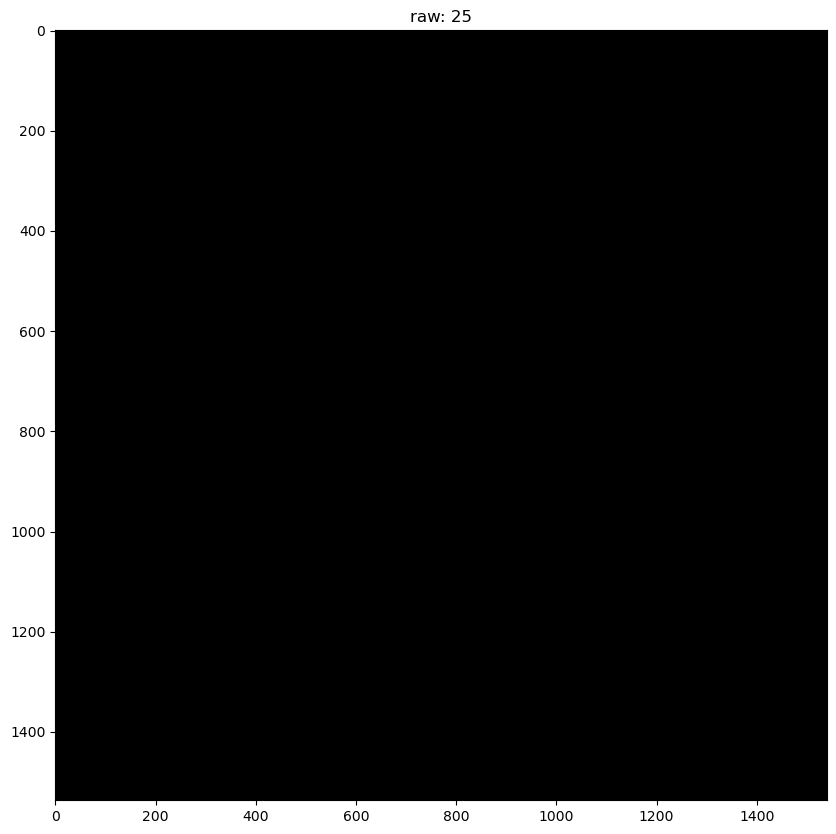

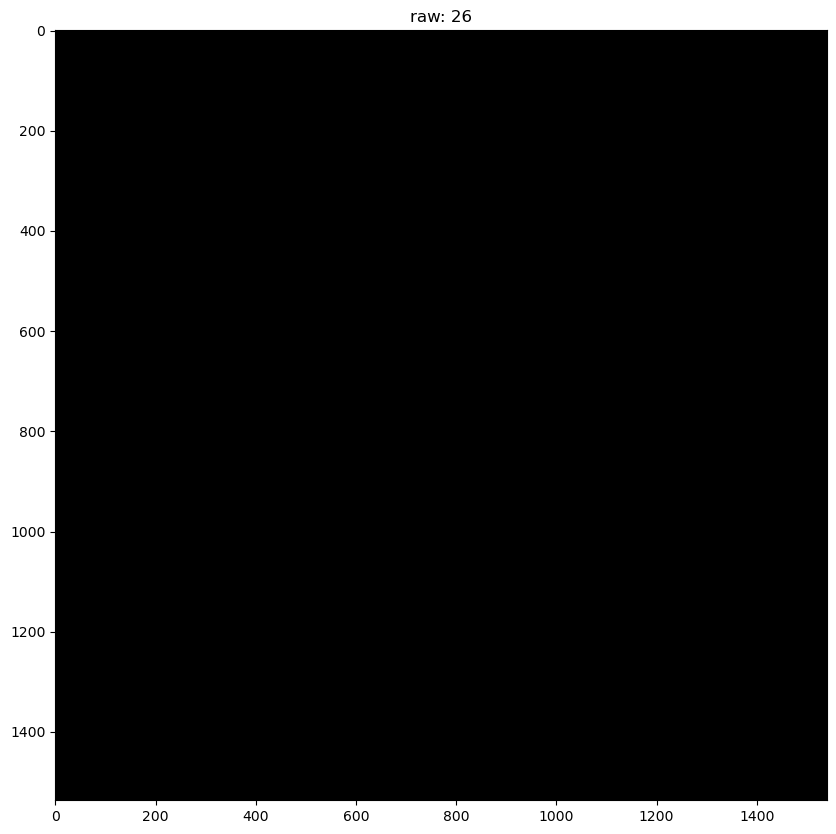

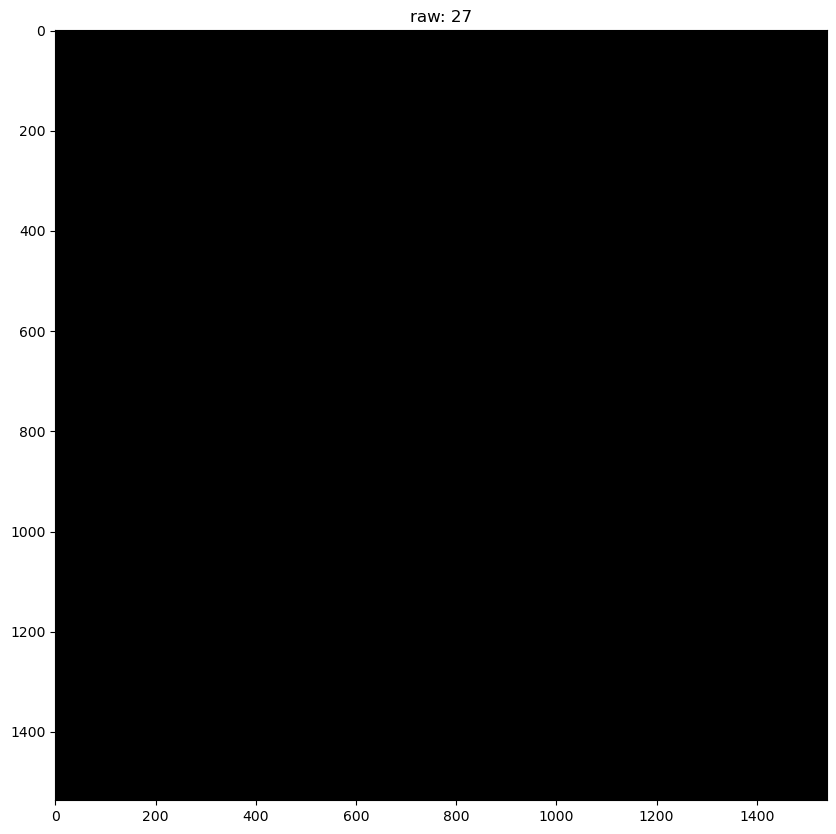

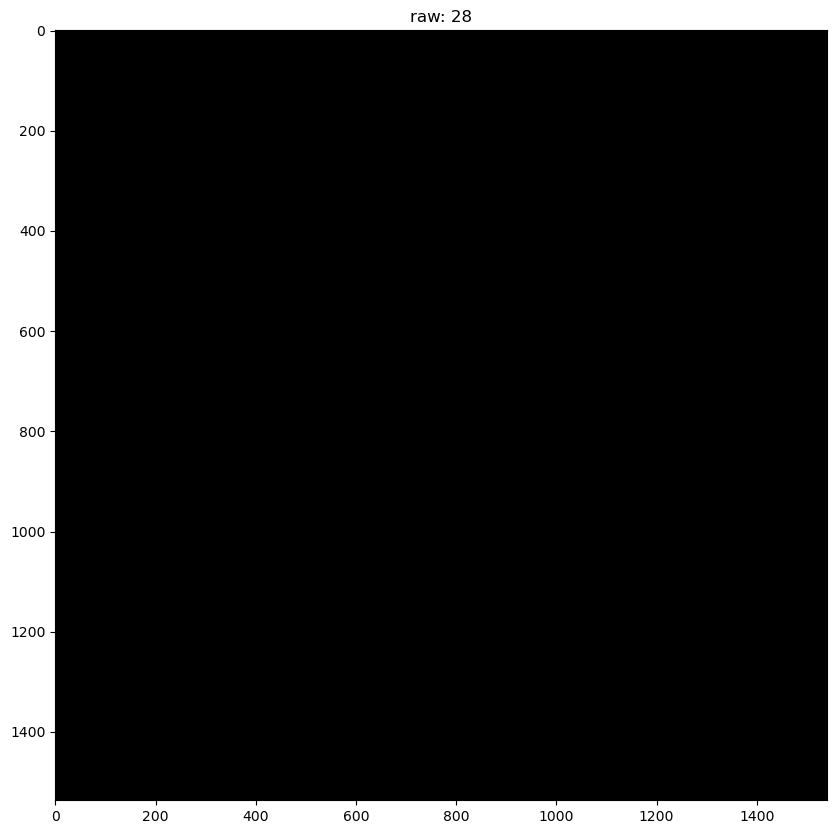

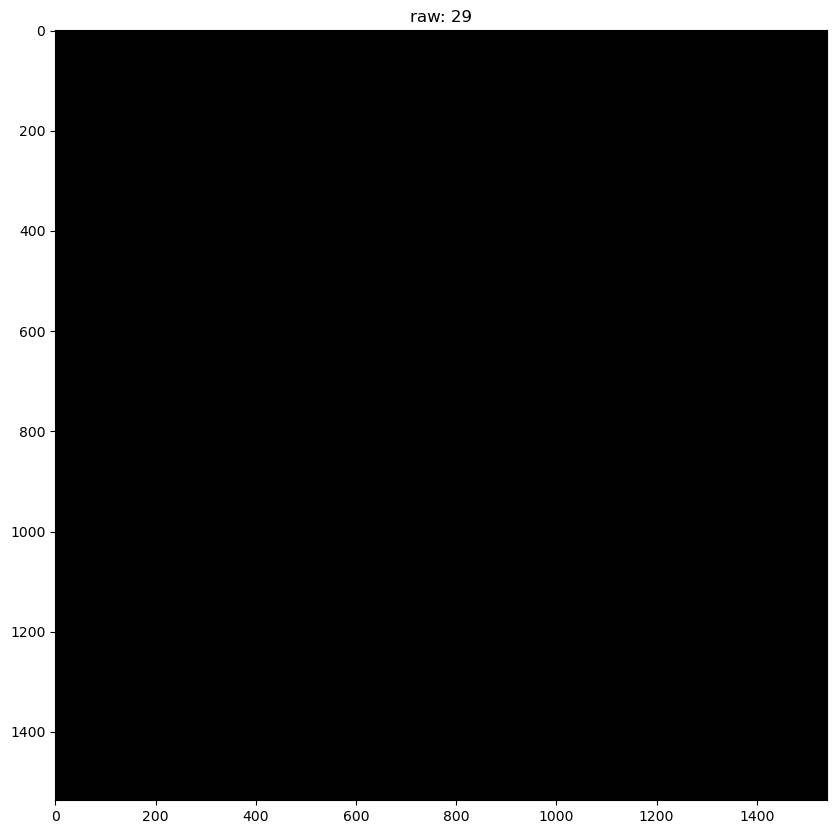

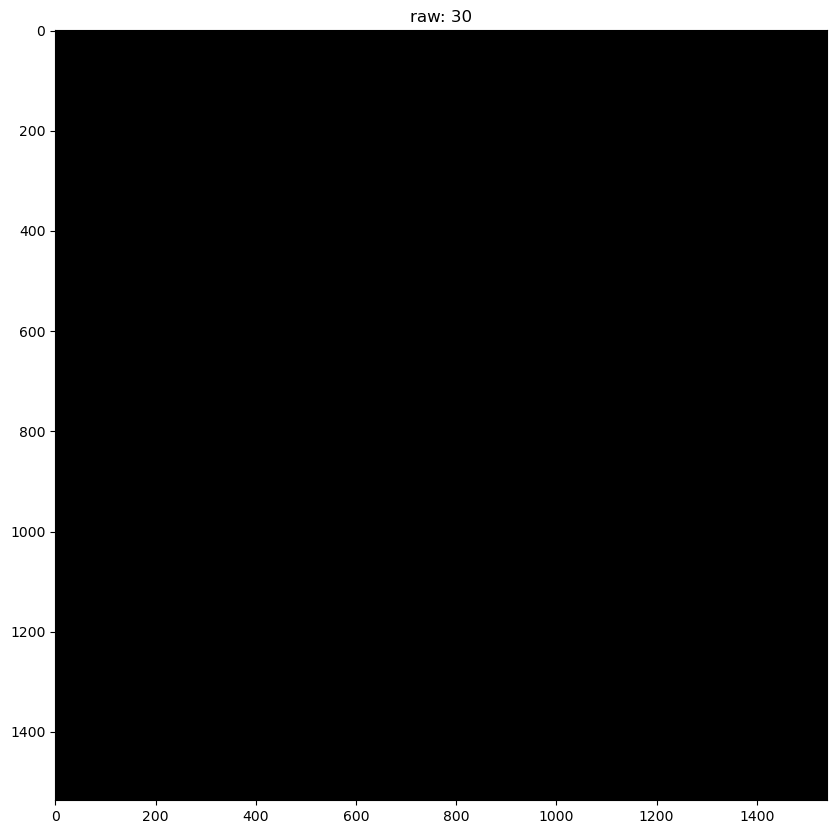

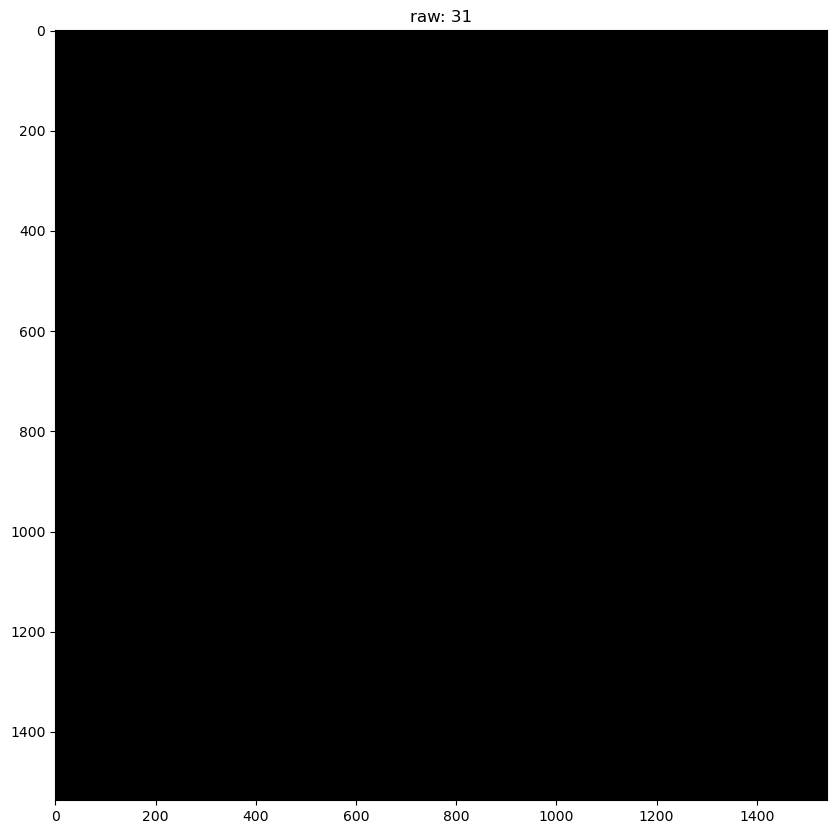

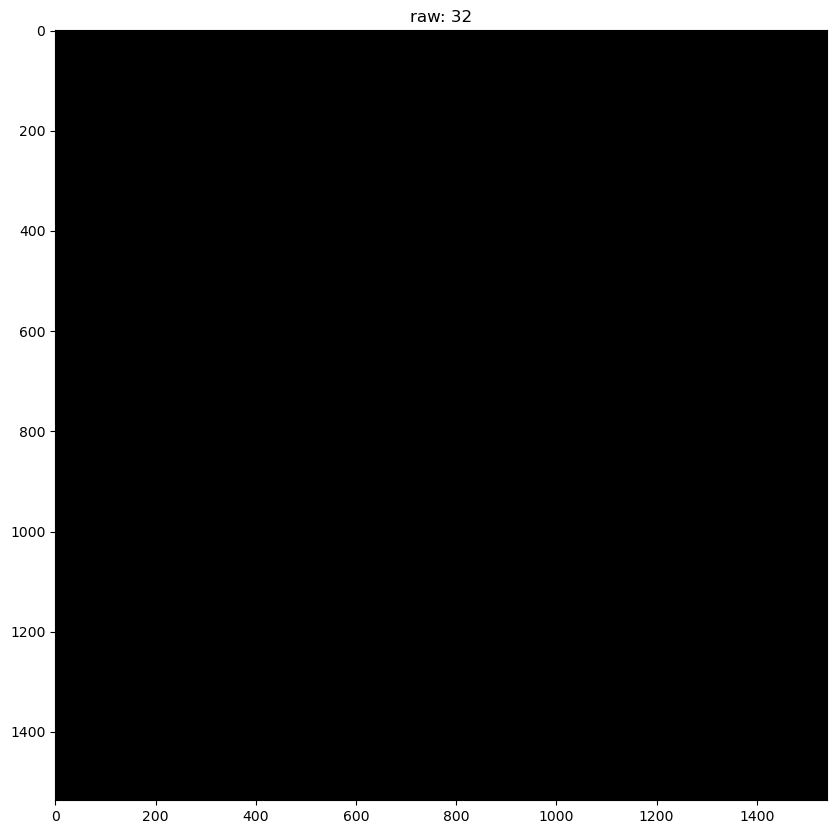

In [ ]:

# get the cell masks
mask_path
cell_mask_path = pathlib.Path(mask_path / "cell_masks.tiff").resolve(strict=True)
cell_mask_img = tifffile.imread(cell_mask_path)
for img_index in range(cell_mask_img.shape[0]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cell_mask_img[img_index], cmap="gray")
    plt.title(f"raw: {img_index}")

# create a whole organoid mask from the cell masks by mergin the masks
# set the expansion factor for merging
expansion_factor = 25
# expand the cell masks 
expanded_cell_mask = np.zeros_like(cell_mask_img)


In [12]:
# reverse sliding window max projection
full_mask_z_stack = []
reconstruction_dict = {index: [] for index in range(original_cyto_z_count)}
print(f"Decoupling the sliding window max projection of {window_size} slices")

# decouple the sliding window max projection based on window size
# each slice in a stack
for z_stack_mask_index in range(len(masks_all)):
    # temoporary list to hold the decoupled z stack
    z_stack_decouple = []
    # decouple
    [z_stack_decouple.append(masks_all[z_stack_mask_index]) for _ in range(window_size)]
    # dull out the decouple slice to the correct z index
    for z_window_index, z_stack_mask in enumerate(z_stack_decouple):
        if not (z_stack_mask_index + z_window_index) >= original_cyto_z_count:
            reconstruction_dict[z_stack_mask_index + z_window_index].append(
                z_stack_mask
            )

# save the reconstruction_dict to a file for downstream decoupling
# np.save(mask_path / "organoid_reconstruction_dict.npy", reconstruction_dict)

Decoupling the sliding window max projection of 3 slices


In [13]:
if in_notebook:
    # masks, flows, styles, diams
    plot = plt.figure(figsize=(10, 5))
    for z in range(len(masks_all)):
        plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(imgs[z], cmap="gray")
        plt.title(f"raw: {z}")
        plt.subplot(122)
        plt.imshow(masks_all[z], cmap="gray")
        plt.title(f"mask: {z}")
        plt.show()

<Figure size 1000x500 with 0 Axes>